In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

# pip install scikeras==0.10.0

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

gpus = tf.config.list_physical_devices('GPU')
print("GPU Available: ", gpus)

## Data Loading and Preprocessing

In [26]:
# Load the EMNIST data
train_dict = pd.read_pickle('emnist_train.pkl')
test_dict = pd.read_pickle('emnist_test.pkl')

In [ ]:
# Convert the data to np arrays
train_images = np.array(train_dict['data'])
train_labels = np.array(train_dict['labels'])
test_images = np.array(test_dict['data'])
test_labels = np.array(test_dict['labels'])

In [ ]:
# Add a channel dimension
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

In [ ]:
# Resize the images to 32x32
train_images = np.array(tf.image.resize(train_images, [32, 32]))
test_images = np.array(tf.image.resize(test_images, [32, 32]))

In [ ]:
# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

In [27]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: <TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Test Dataset: <TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## Model: VGG11

#### 1. Implement VGG11 Network Structure

In [57]:
def VGG11(input_shape, num_classes=62):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    # Conv Layer Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [58]:
# Create VGG11 baseline model
vgg11_model = VGG11(input_shape=(32, 32, 1), num_classes=62)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss = keras.losses.SparseCategoricalCrossentropy()
vgg11_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

vgg11_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_129 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_130 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 conv2d_131 (Conv2D)         (None, 8, 8, 256)       

In [59]:
# Train the VGG11 baseline model
history = vgg11_model.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10)

Epoch 1/10
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4911 - accuracy: 0.6009 - val_loss: 0.5952 - val_accuracy: 0.8054
Epoch 2/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.6773 - accuracy: 0.7822 - val_loss: 0.4763 - val_accuracy: 0.8348
Epoch 3/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.5509 - accuracy: 0.8153 - val_loss: 0.4368 - val_accuracy: 0.8463
Epoch 4/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.4854 - accuracy: 0.8333 - val_loss: 0.4214 - val_accuracy: 0.8503
Epoch 5/10
1563/1563 [==============================] - 26s 17ms/step - loss: 0.4448 - accuracy: 0.8438 - val_loss: 0.4092 - val_accuracy: 0.8558
Epoch 6/10
1563/1563 [==============================] - 29s 18ms/step - loss: 0.4128 - accuracy: 0.8523 - val_loss: 0.4073 - val_accuracy: 0.8553
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.3872 - accuracy: 0.8595 - val_loss: 0.4002 -

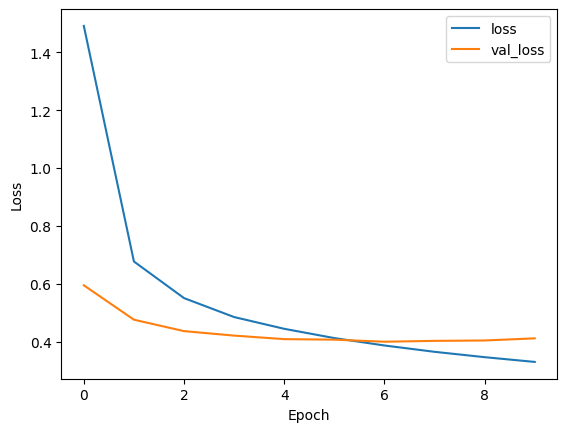

In [60]:
# Plot the loss vs epoch graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 53ms/step


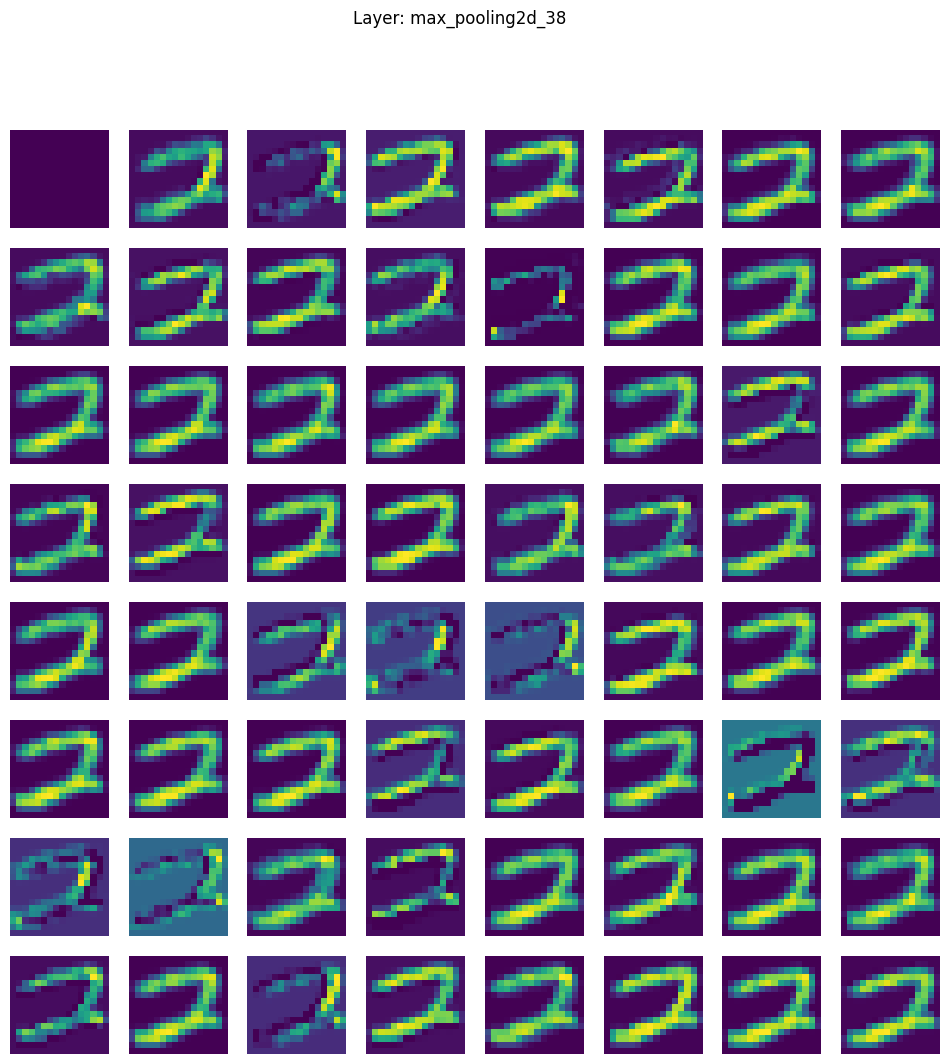

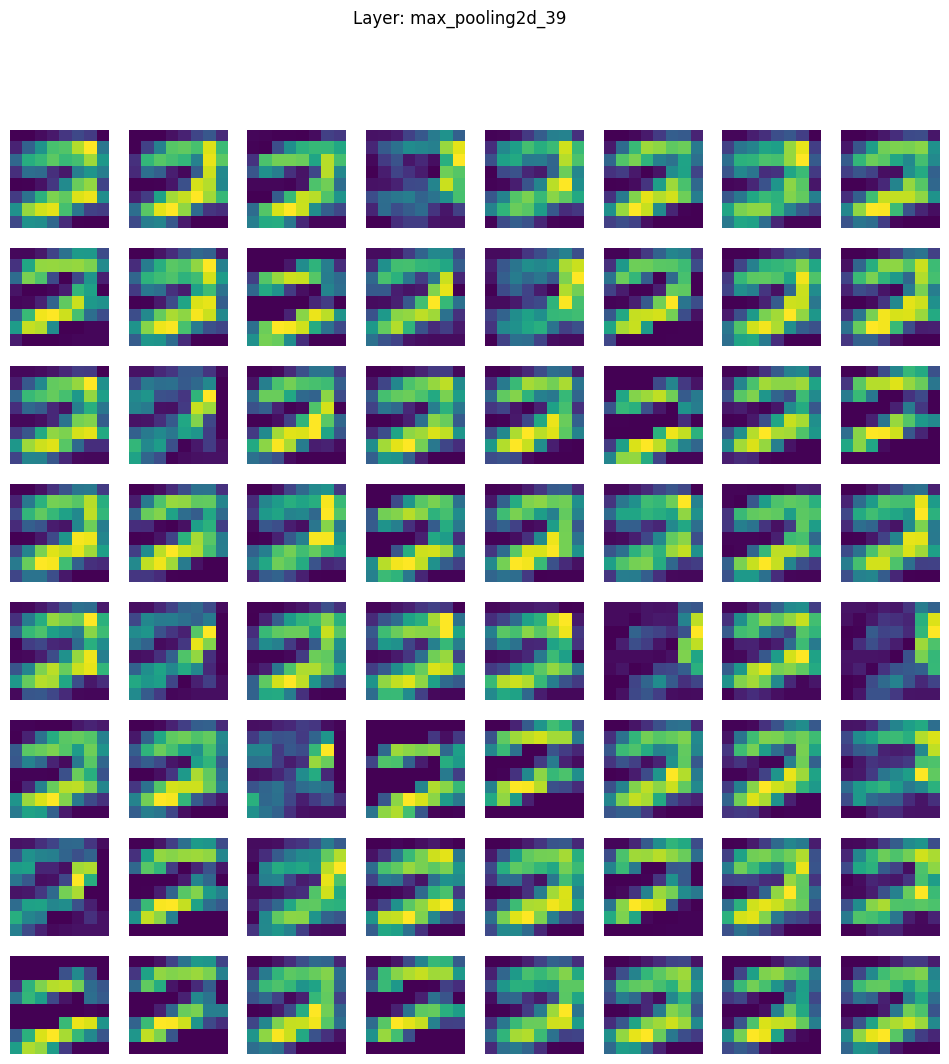

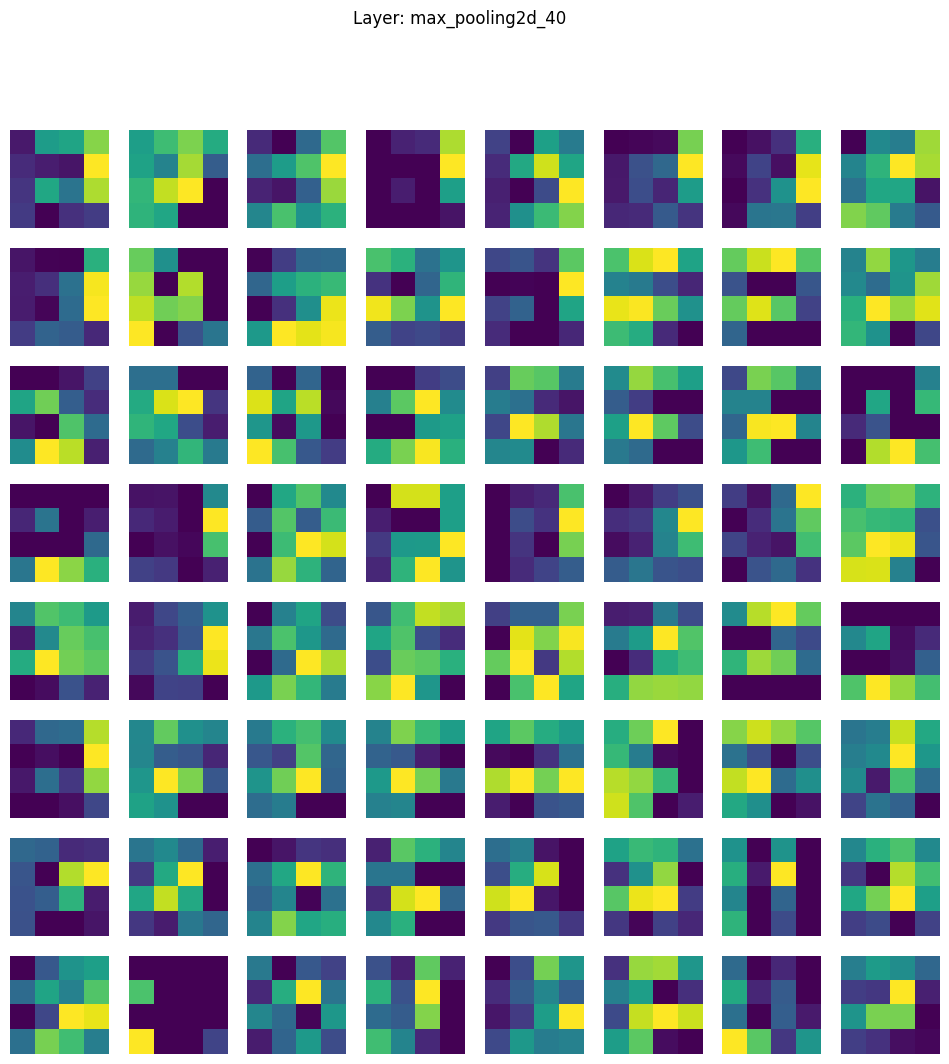

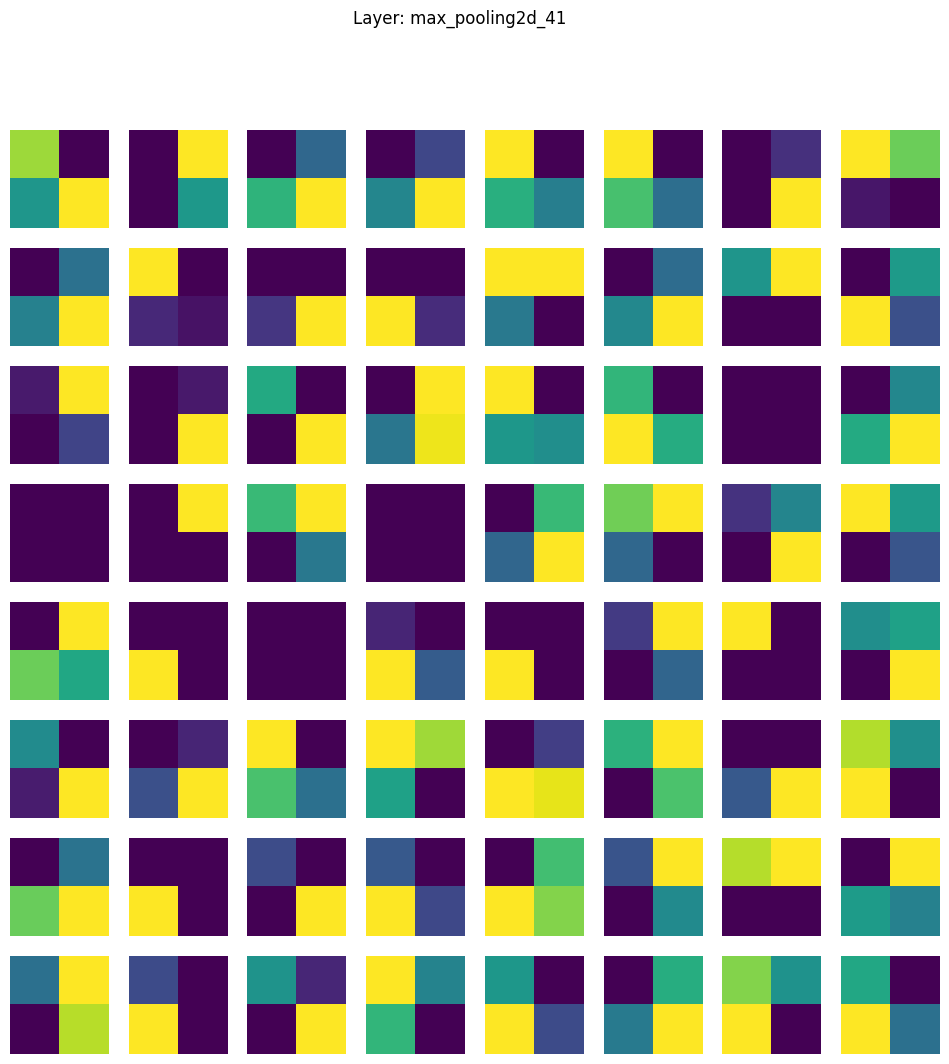

In [48]:
# Visualize hidden layers output
layer_outputs = [layer.output for layer in vgg11_model.layers if 'max_pooling2d' in layer.name]
activation_model = models.Model(inputs=vgg11_model.input, outputs=layer_outputs)
activations = activation_model.predict(test_images[0][np.newaxis, ...])
layer_names = [layer.name for layer in vgg11_model.layers if 'max_pooling2d' in layer.name]
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]      
    plt.figure(figsize=(12,12))
    for i in range(n_features):
        # Display only the first 64 features
        if i >= 64:
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Layer: {layer_name}")
    plt.show()

#### 2. Hyperparameter tuning

In [ ]:
# Define a function to create the model
def create_model_vgg11(learning_rate, optimizer_name):
    optimizer_dict = {
    'adam': keras.optimizers.Adam,
    'adagrad': keras.optimizers.Adagrad,
    'rmsprop': keras.optimizers.RMSprop
    }
    if optimizer_name in optimizer_dict:
        optimizer = optimizer_dict[optimizer_name](learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    model = VGG11(input_shape=(32, 32, 1), num_classes=62)
    loss = keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
# Define the hyperparameters
param_grid = {
    'model__learning_rate': [1e-5, 5e-5, 1e-4],
    'model__optimizer_name': ['adam', 'adagrad','rmsprop']
}

In [ ]:
# Wrap the model using KerasClassifier
# Use scikeras.wrappers.KerasClassifier to wrap the model.
keras_model = KerasClassifier(model=create_model_vgg11, epochs=10)

# Perform the grid search
skf = StratifiedKFold(n_splits=3, shuffle=True)
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=skf)
grid_result = grid.fit(train_images, train_labels)

In [ ]:
# Print the results
# Mean measures the best-performing hyperparameter combination.
# Standard deviation measures the stability of the model's performance.
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

In [ ]:
# Train the model with the best hyperparameters
best_lr_vgg11 = grid_result.best_params_['learning_rate']
best_opt_vgg11 = grid_result.best_params_['optimizer']
best_model_vgg11 = create_model_vgg11(best_lr_vgg11, best_opt_vgg11)
history = best_model_vgg11.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10)

## Model: ResNet18

#### 1. Implement ResNet18 Network Structure
K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.

In [49]:
def residual_block(x, filters, kernel_size=3, downsample=False):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=(2 if downsample else 1), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Add downsample layer
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut connection
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    
    return x

def ResNet18(input_shape, num_classes=62):
    inputs = layers.Input(shape=input_shape)

    # Conv Layer Block 1
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual Block 1
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Residual Block 2
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128)

    # Residual Block 3
    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256)

    # Residual Block 4
    # x = residual_block(x, filters=512, downsample=True)
    # x = residual_block(x, filters=512)

    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    
    return model

In [50]:
# Create ResNet18 baseline model
resnet18_model = ResNet18(input_shape=(32, 32, 1), num_classes=62)

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss = keras.losses.SparseCategoricalCrossentropy()
resnet18_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

resnet18_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_113 (Conv2D)            (None, 16, 16, 64)   3200        ['input_14[0][0]']               
                                                                                                  
 batch_normalization_55 (BatchN  (None, 16, 16, 64)  256         ['conv2d_113[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_42 (MaxPooling2D  (None, 8, 8, 64)    0           ['batch_normalization_55[0

In [51]:
# Train the baseline model
history = resnet18_model.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10)

Epoch 1/10
1563/1563 [==============================] - 20s 12ms/step - loss: 3.0262 - accuracy: 0.3387 - val_loss: 1.5474 - val_accuracy: 0.6219
Epoch 2/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.5694 - accuracy: 0.6091 - val_loss: 1.0061 - val_accuracy: 0.7276
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1169 - accuracy: 0.6978 - val_loss: 0.7700 - val_accuracy: 0.7725
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8874 - accuracy: 0.7471 - val_loss: 0.6507 - val_accuracy: 0.7994
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7504 - accuracy: 0.7765 - val_loss: 0.5875 - val_accuracy: 0.8146
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.6633 - accuracy: 0.7970 - val_loss: 0.5489 - val_accuracy: 0.8245
Epoch 7/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.5974 - accuracy: 0.8124 - val_loss: 0.5240 -

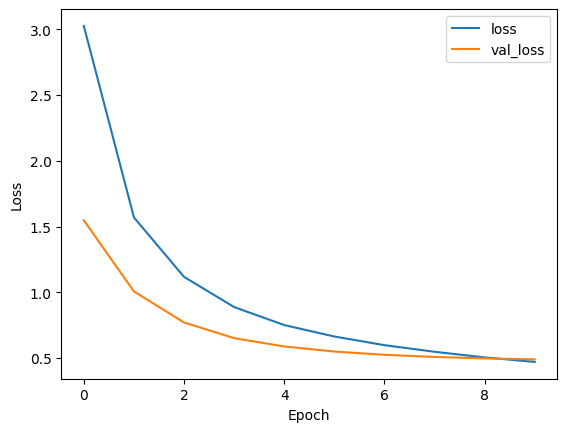

In [52]:
# Plot the loss vs epoch graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 163ms/step


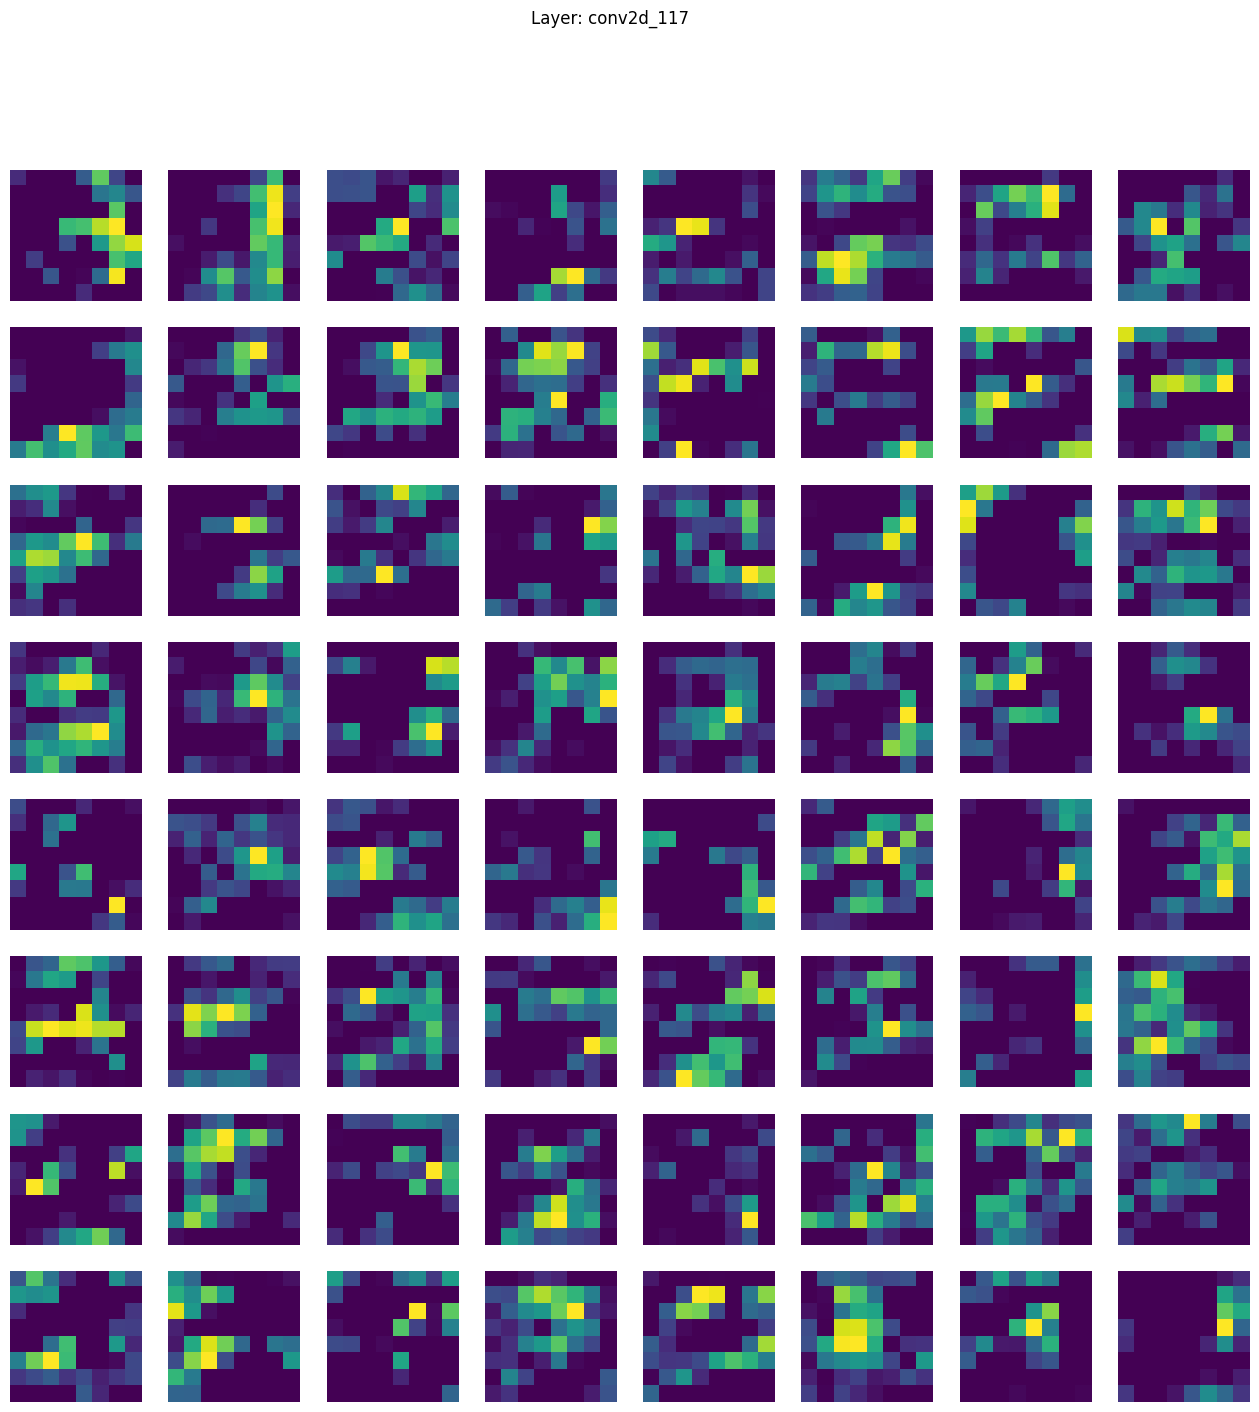

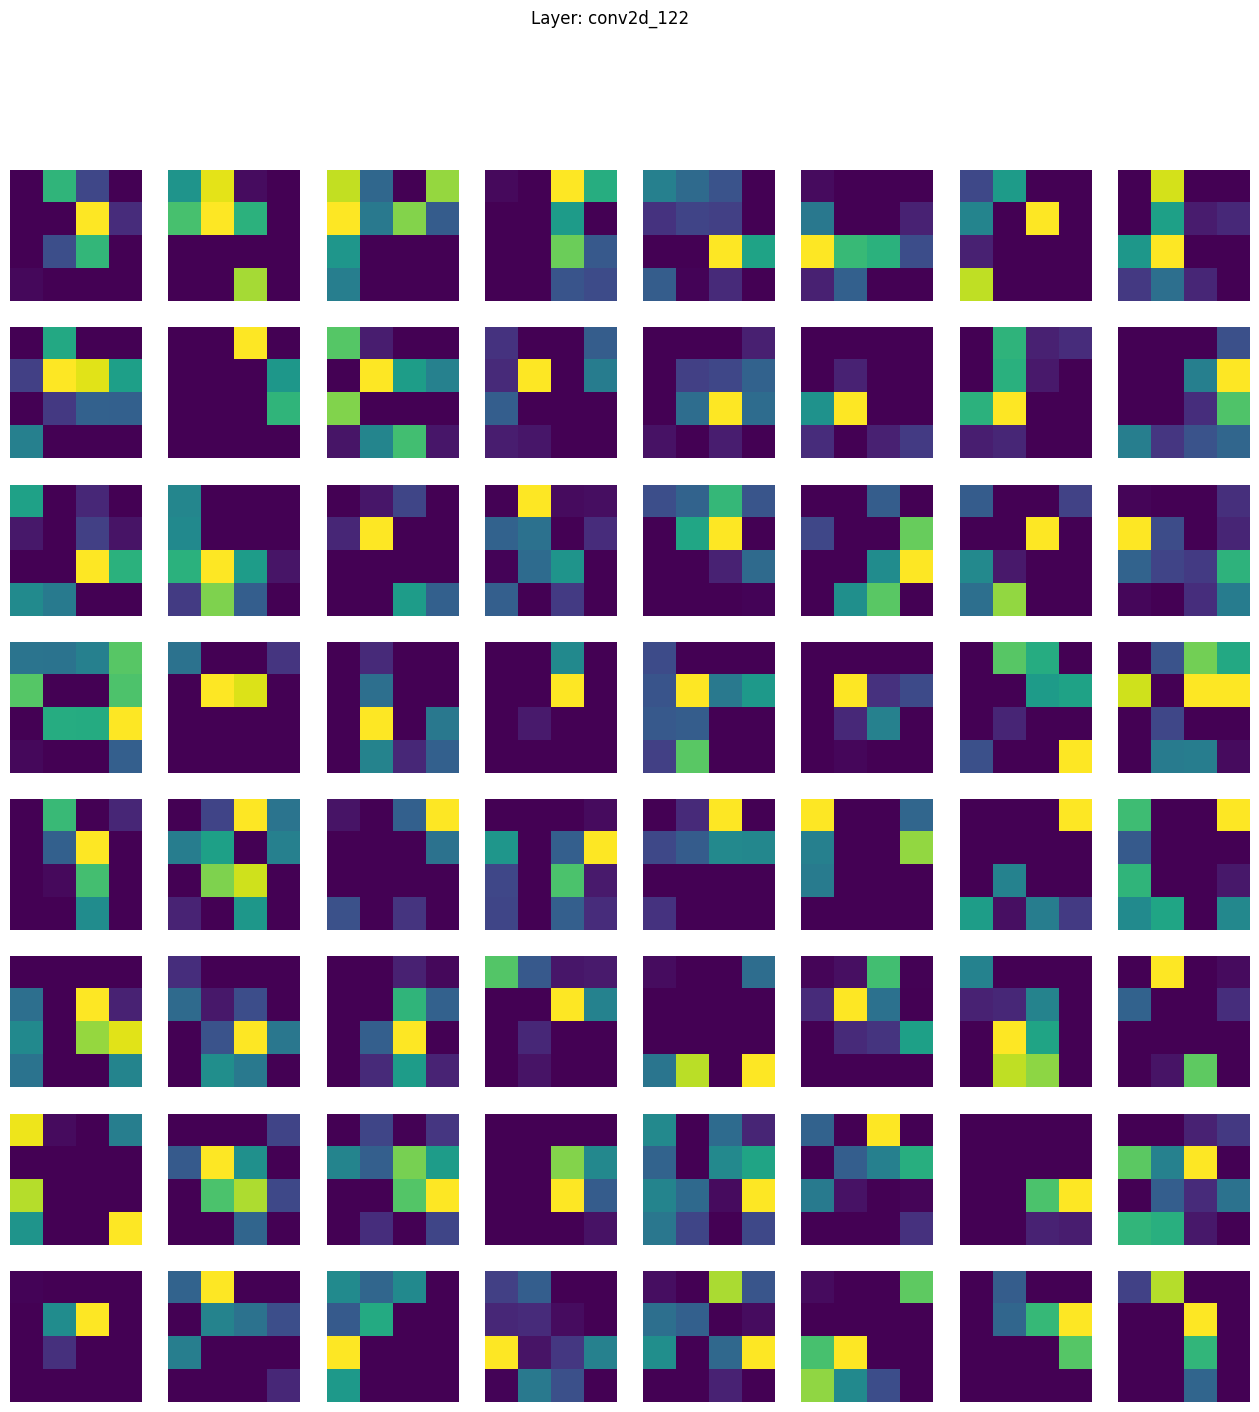

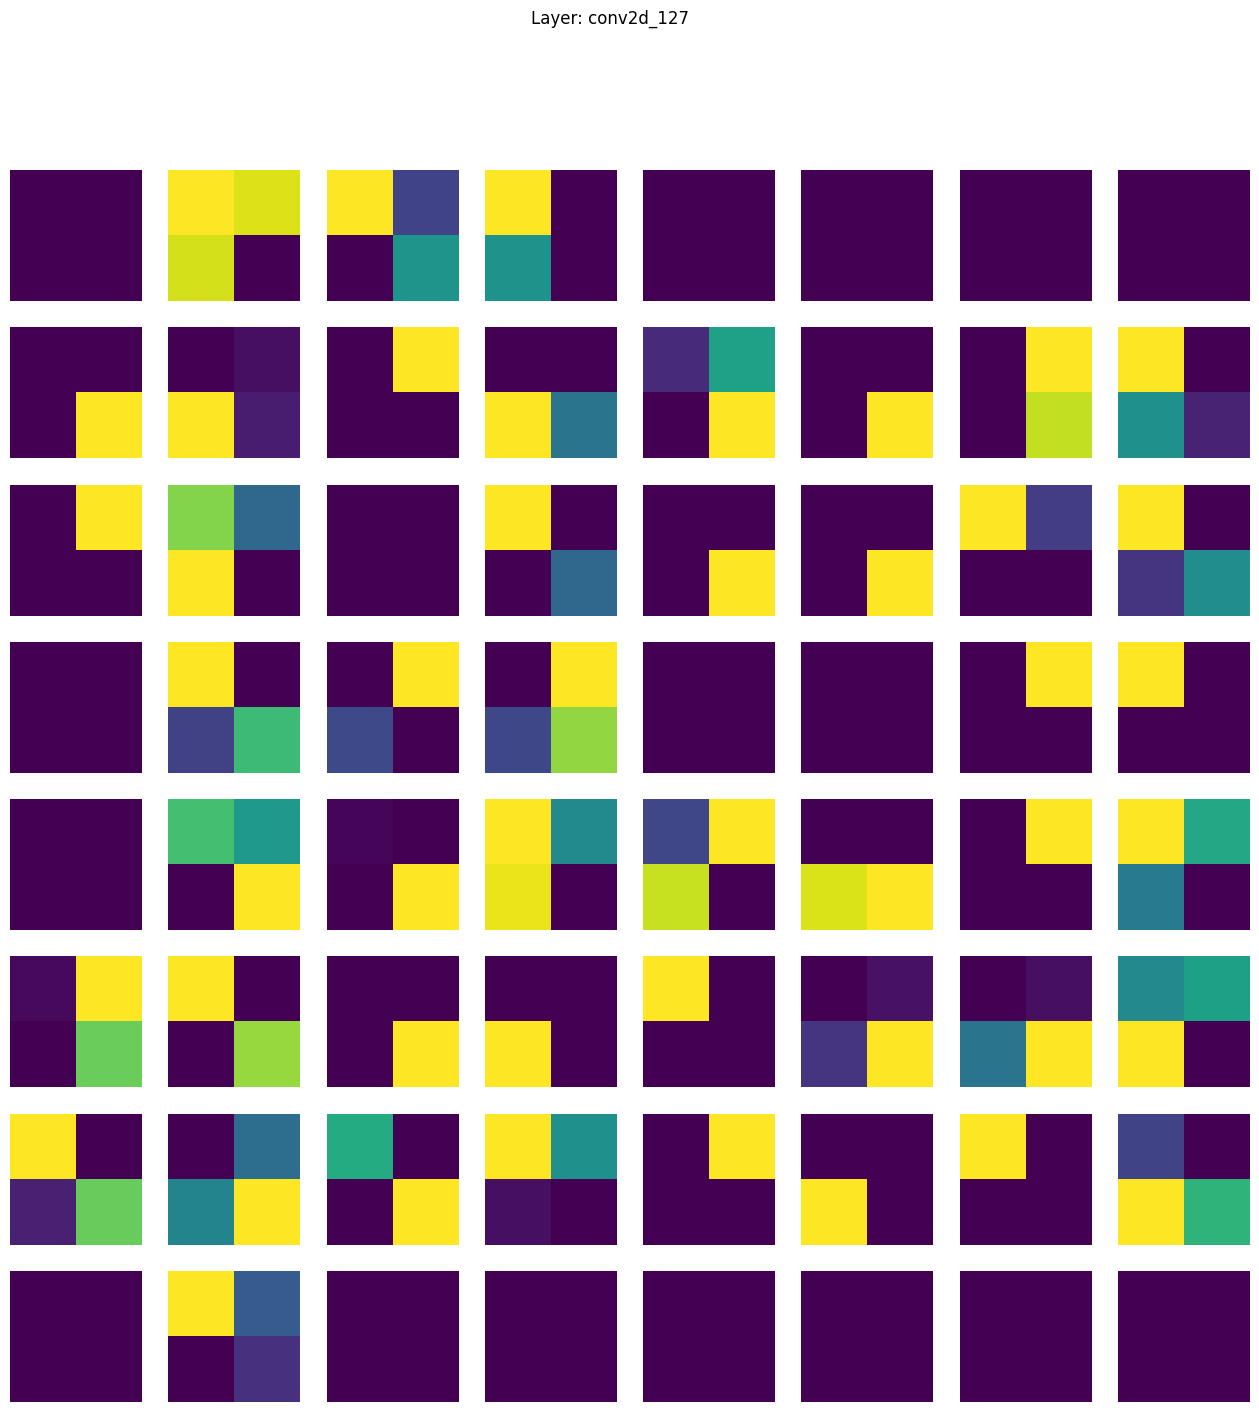

In [61]:
# Visualize hidden layers output
layer_outputs = [layer.output for layer in resnet18_model.layers if 'conv2d_117' in layer.name or 'conv2d_122' in layer.name or 'conv2d_127' in layer.name]
activation_model = models.Model(inputs=resnet18_model.input, outputs=layer_outputs)
activations = activation_model.predict(test_images[0][np.newaxis, ...])
layer_names = [layer.name for layer in resnet18_model.layers if 'conv2d_117' in layer.name or 'conv2d_122' in layer.name or 'conv2d_127' in layer.name]
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]      
    plt.figure(figsize=(16,16))
    for i in range(n_features):
        # Display only the first 64 features
        if i >= 64:
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Layer: {layer_name}")
    plt.show()

#### 2. Hyperparameter tuning

In [63]:
# Define a function to create the model
def create_model_resnet18(learning_rate, optimizer_name):
    optimizer_dict = {
    'adam': keras.optimizers.Adam,
    'adagrad': keras.optimizers.Adagrad,
    'rmsprop': keras.optimizers.RMSprop
    }
    if optimizer_name in optimizer_dict:
        optimizer = optimizer_dict[optimizer_name](learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    model = ResNet18(input_shape=(32, 32, 1), num_classes=62)
    loss = keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
# Define the hyperparameters
param_grid = {
    'model__learning_rate': [5e-5, 1e-4, 5e-4],
    'model__optimizer_name': ['adam', 'adagrad','rmsprop']
}

In [ ]:
# Wrap the model using KerasClassifier
# Use scikeras.wrappers.KerasClassifier to wrap the model.
keras_model = KerasClassifier(model=create_model_resnet18, epochs=10)

# Perform the grid search
skf = StratifiedKFold(n_splits=3, shuffle=True)
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=skf)
grid_result = grid.fit(train_images, train_labels)

In [ ]:
# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

In [ ]:
# Train the model with the best hyperparameters
best_lr_resnet18 = grid_result.best_params_['learning_rate']
best_opt_resnet18 = grid_result.best_params_['optimizer']
best_model_resnet18 = create_model_resnet18(best_lr_resnet18, best_opt_resnet18)
history = best_model_resnet18.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10)